## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print('✅ Imports successful')

✅ Imports successful


## 2. Load PepsiCo Data

In [2]:
# Configuration
ticker = 'PEP'
data_root = Path.cwd().parent / 'data'

# Load price data
price_path = data_root / 'curated' / 'tickers' / 'exchange=us' / f'ticker={ticker}' / 'prices' / 'freq=monthly'

price_files = []
for year_dir in sorted(price_path.glob('year=*')):
    parquet_file = year_dir / 'part-000.parquet'
    if parquet_file.exists():
        price_files.append(pd.read_parquet(parquet_file))

prices_df = pd.concat(price_files, ignore_index=True)
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df = prices_df.sort_values('date')

print(f'✅ Loaded {len(prices_df)} monthly price observations for {ticker}')
print(f'Date range: {prices_df["date"].min().date()} to {prices_df["date"].max().date()}')
print(f'\nLatest price: ${prices_df["adj_close"].iloc[-1]:.2f}')
print(f'Latest date: {prices_df["date"].iloc[-1].date()}')

prices_df.tail()

✅ Loaded 143 monthly price observations for PEP
Date range: 2014-01-31 to 2025-11-28

Latest price: $146.33
Latest date: 2025-11-28


,gvkey,date,open,high,low,close,volume,adj_open,adj_high,adj_low,adj_close,adj_volume,div_cash,split_factor,exchange,currency,freq,year
138,8479,2025-07-31,132.59,147.03,132.47,137.92,214129443,131.31,145.62,131.20,136.59,214129443,0.00,1.00,us,USD,monthly,2025
139,8479,2025-08-29,139.10,154.61,138.29,148.65,161777110,137.77,153.12,136.96,147.22,161777110,0.00,1.00,us,USD,monthly,2025
140,8479,2025-09-30,157.44,157.80,139.12,140.44,169058049,155.92,156.28,139.12,140.44,169058049,1.42,1.00,us,USD,monthly,2025
141,8479,2025-10-31,140.81,155.19,138.59,146.09,161948359,140.81,155.19,138.59,146.09,161948359,0.00,1.00,us,USD,monthly,2025
142,8479,2025-11-28,145.86,149.83,141.26,146.33,111268348,145.86,149.83,141.26,146.33,111268348,0.00,1.00,us,USD,monthly,2025


### 2.1 Load ESG Data

In [3]:
# Load ESG data
esg_path = data_root / 'curated' / 'tickers' / 'exchange=us' / f'ticker={ticker}' / 'esg'

esg_files = []
for year_dir in sorted(esg_path.glob('year=*')):
    parquet_file = year_dir / 'part-000.parquet'
    if parquet_file.exists():
        esg_files.append(pd.read_parquet(parquet_file))

if esg_files:
    esg_df = pd.concat(esg_files, ignore_index=True)
    esg_df['date'] = pd.to_datetime(esg_df['date'])
    esg_df = esg_df.sort_values('date')
    
    print(f'✅ Loaded {len(esg_df)} ESG observations')
    print(f'Date range: {esg_df["date"].min().date()} to {esg_df["date"].max().date()}')
    
    # Show latest ESG scores
    latest_esg = esg_df.iloc[-1]
    print(f'\nLatest ESG Scores (as of {latest_esg["date"].date()}):')
    print(f'  Total ESG Score: {latest_esg["esg_score"]:.2f}')
    print(f'  Environment:     {latest_esg["environmental_pillar_score"]:.2f}')
    print(f'  Social:          {latest_esg["social_pillar_score"]:.2f}')
    print(f'  Governance:      {latest_esg["governance_pillar_score"]:.2f}')
    
    esg_df.tail()
else:
    print('⚠️ No ESG data found')
    esg_df = pd.DataFrame()

✅ Loaded 132 ESG observations
Date range: 2014-01-31 to 2024-12-31

Latest ESG Scores (as of 2024-12-31):
  Total ESG Score: 80.40
  Environment:     56.19
  Social:          89.71
  Governance:      92.32


### 2.2 Load Expected Returns (from Extended CAPM)

In [4]:
# Load expected returns
er_file = data_root / 'results' / 'expected_returns' / 'expected_returns.parquet'

if er_file.exists():
    er_df = pd.read_parquet(er_file)
    er_df['date'] = pd.to_datetime(er_df['date'])
    
    # Filter for PEP
    pep_er = er_df[er_df['ticker'] == ticker].copy()
    pep_er = pep_er.sort_values('date')
    
    print(f'✅ Loaded {len(pep_er)} expected return observations')
    
    # Show latest
    latest_er = pep_er.iloc[-1]
    print(f'\nLatest Expected Return (as of {latest_er["date"].date()}):')
    print(f'  Annual ER:    {latest_er["ER_annual"]*100:.2f}%')
    print(f'  Beta Market:  {latest_er["beta_market"]:.2f}')
    print(f'  Beta ESG:     {latest_er["beta_ESG"]:.2f}')
    
    pep_er.tail()
else:
    print('⚠️ Expected returns not found. Run extend_capm.py first.')
    pep_er = pd.DataFrame()

✅ Loaded 107 expected return observations

Latest Expected Return (as of 2024-12-31):
  Annual ER:    10.00%
  Beta Market:  0.73
  Beta ESG:     0.93


## 3. Current Valuation Snapshot

Get current price and basic valuation metrics as starting point.

In [5]:
# Current price and returns
current_price = prices_df['adj_close'].iloc[-1]
current_date = prices_df['date'].iloc[-1]

# Calculate returns for different periods
prices_df['return'] = prices_df['adj_close'].pct_change()

# Recent returns
returns_1m = prices_df['adj_close'].iloc[-1] / prices_df['adj_close'].iloc[-2] - 1
returns_3m = prices_df['adj_close'].iloc[-1] / prices_df['adj_close'].iloc[-4] - 1
returns_6m = prices_df['adj_close'].iloc[-1] / prices_df['adj_close'].iloc[-7] - 1
returns_1y = prices_df['adj_close'].iloc[-1] / prices_df['adj_close'].iloc[-13] - 1
returns_ytd = prices_df[prices_df['date'].dt.year == current_date.year]['return'].sum()

print('='*70)
print('PEPSICO (PEP) - CURRENT VALUATION SNAPSHOT')
print('='*70)
print(f'\nAs of: {current_date.date()}')
print(f'Current Price: ${current_price:.2f}')

print(f'\nRecent Performance:')
print(f'  1 Month:  {returns_1m*100:>6.2f}%')
print(f'  3 Month:  {returns_3m*100:>6.2f}%')
print(f'  6 Month:  {returns_6m*100:>6.2f}%')
print(f'  1 Year:   {returns_1y*100:>6.2f}%')
print(f'  YTD:      {returns_ytd*100:>6.2f}%')

# Volatility
vol_monthly = prices_df['return'].std()
vol_annual = vol_monthly * np.sqrt(12)

print(f'\nRisk Metrics:')
print(f'  Volatility (annual): {vol_annual*100:.2f}%')

if not pep_er.empty:
    print(f'  Beta (market):       {latest_er["beta_market"]:.2f}')
    print(f'  Beta (ESG):          {latest_er["beta_ESG"]:.2f}')
    print(f'\nForward-Looking:')
    print(f'  Expected Return:     {latest_er["ER_annual"]*100:.2f}% (Extended CAPM)')

PEPSICO (PEP) - CURRENT VALUATION SNAPSHOT

As of: 2025-11-28
Current Price: $146.33

Recent Performance:
  1 Month:    0.16%
  3 Month:   -0.60%
  6 Month:   13.63%
  1 Year:    -7.02%
  YTD:        0.24%

Risk Metrics:
  Volatility (annual): 14.65%
  Beta (market):       0.73
  Beta (ESG):          0.93

Forward-Looking:
  Expected Return:     10.00% (Extended CAPM)


## 4. Historical Performance Analysis

Understand PepsiCo's historical track record to benchmark implied expectations.

### 4.1 Price Performance Over Time

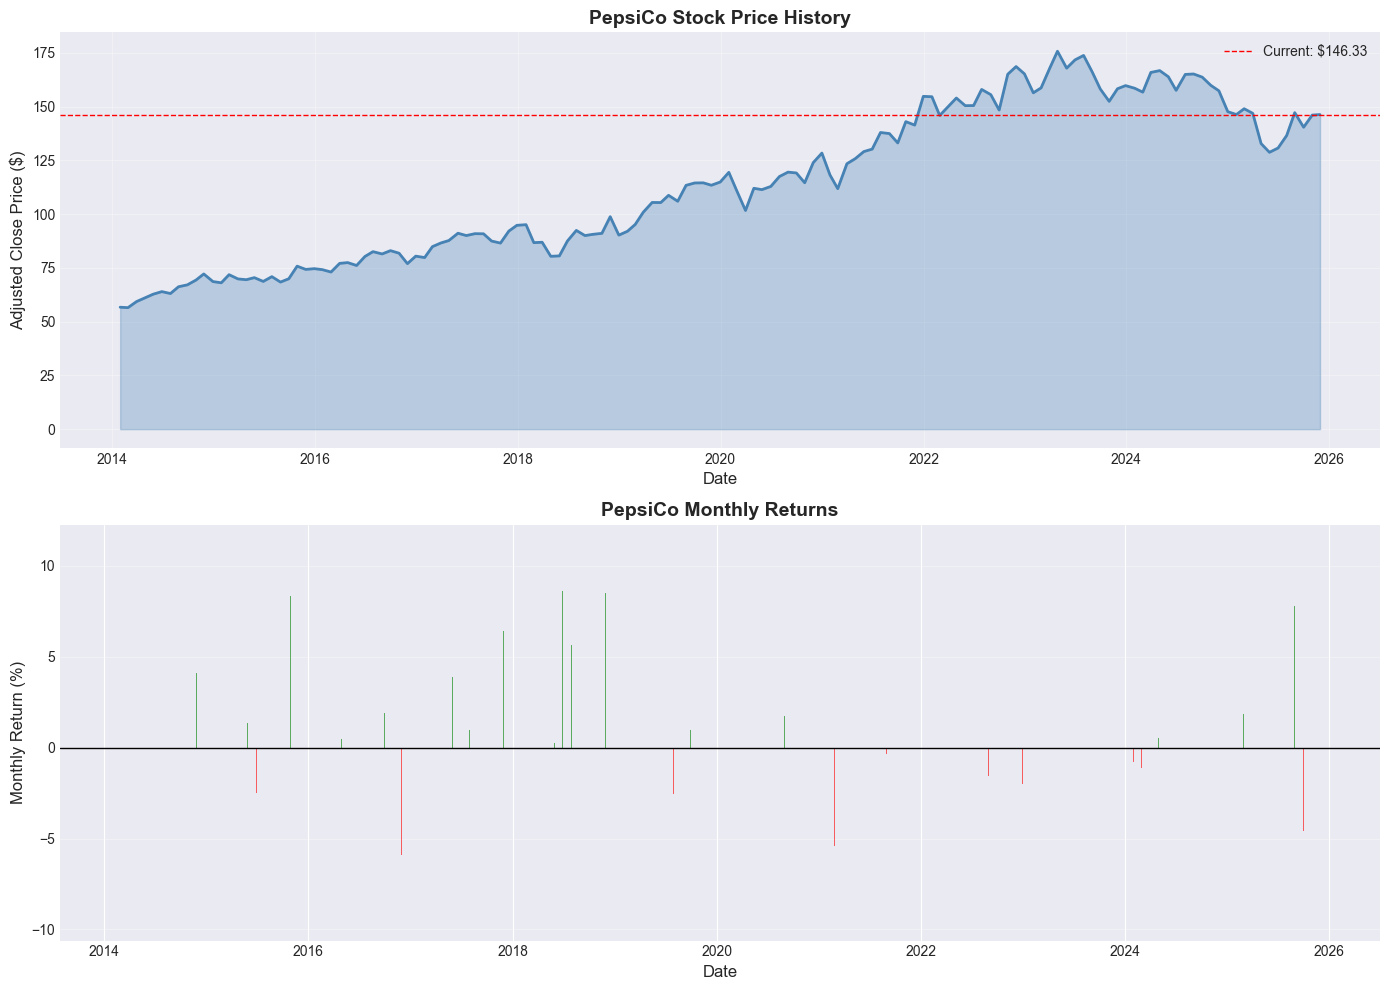

✅ Price performance visualized


In [6]:
# Plot price history
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Adjusted close price
ax = axes[0]
ax.plot(prices_df['date'], prices_df['adj_close'], linewidth=2, color='steelblue')
ax.fill_between(prices_df['date'], prices_df['adj_close'], alpha=0.3, color='steelblue')
ax.axhline(current_price, color='red', linestyle='--', linewidth=1, label=f'Current: ${current_price:.2f}')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Adjusted Close Price ($)', fontsize=12)
ax.set_title('PepsiCo Stock Price History', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Monthly returns
ax = axes[1]
colors = ['green' if r > 0 else 'red' for r in prices_df['return']]
ax.bar(prices_df['date'], prices_df['return']*100, color=colors, alpha=0.6)
ax.axhline(0, color='black', linewidth=1)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Monthly Return (%)', fontsize=12)
ax.set_title('PepsiCo Monthly Returns', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print('✅ Price performance visualized')

### 4.2 Rolling Performance Metrics

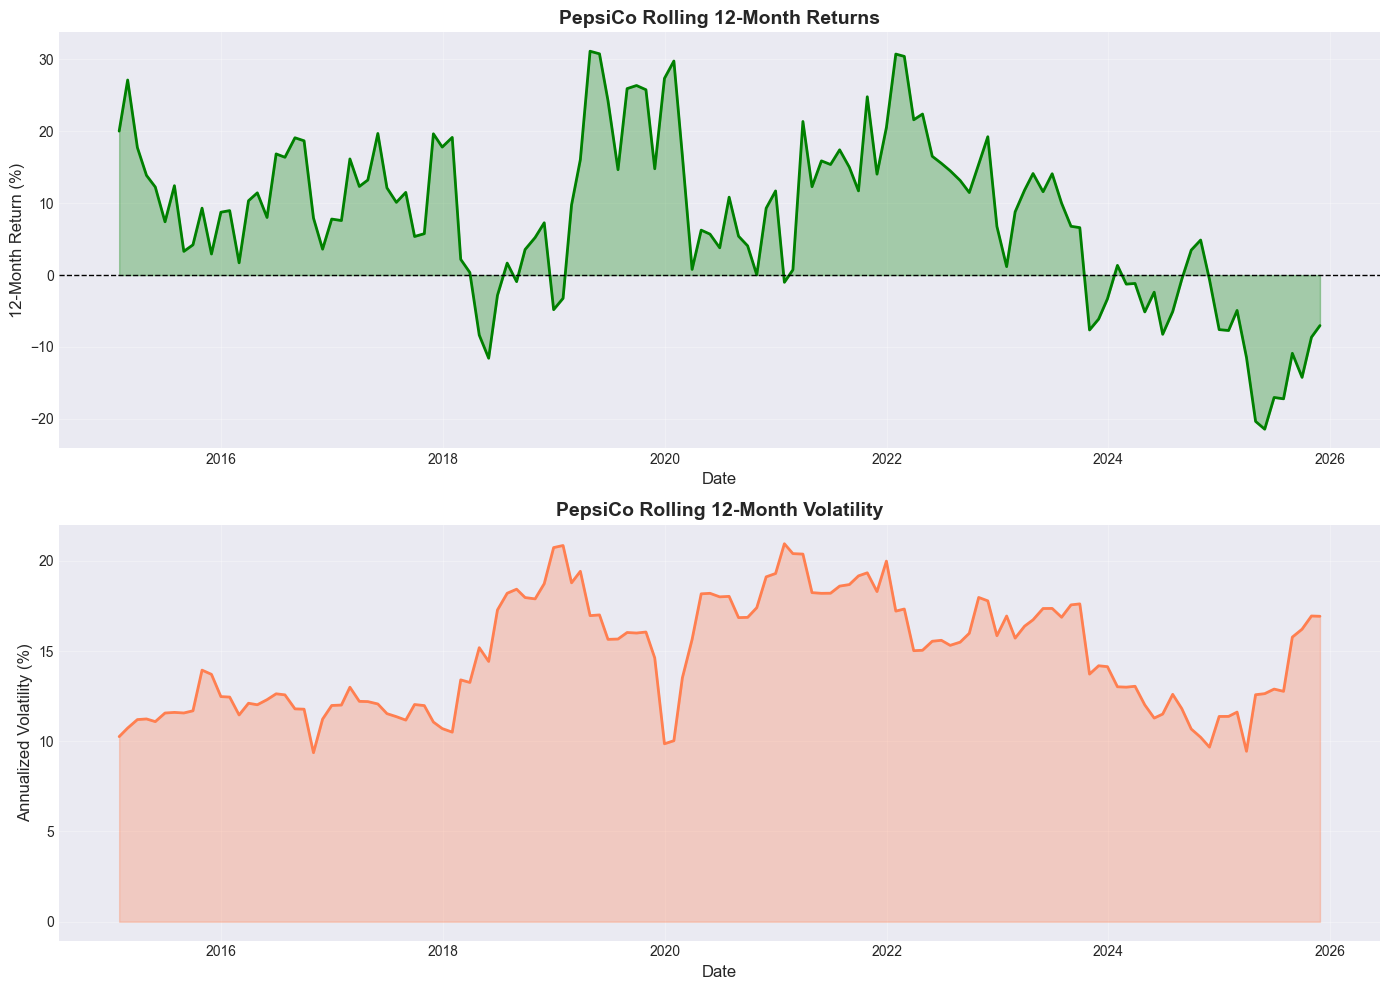

Historical Performance Summary:
  Average 12M Return:  8.18%
  Median 12M Return:   8.97%
  Std Dev 12M Return:  11.35%
  Average Volatility:  14.71%


In [7]:
# Calculate rolling metrics
window = 12  # 12 months = 1 year

prices_df['rolling_return_12m'] = prices_df['adj_close'].pct_change(window)
prices_df['rolling_vol_12m'] = prices_df['return'].rolling(window).std() * np.sqrt(12)

# Plot rolling metrics
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Rolling 12-month return
ax = axes[0]
ax.plot(prices_df['date'], prices_df['rolling_return_12m']*100, linewidth=2, color='green')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.fill_between(prices_df['date'], prices_df['rolling_return_12m']*100, alpha=0.3, color='green')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('12-Month Return (%)', fontsize=12)
ax.set_title('PepsiCo Rolling 12-Month Returns', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Rolling volatility
ax = axes[1]
ax.plot(prices_df['date'], prices_df['rolling_vol_12m']*100, linewidth=2, color='coral')
ax.fill_between(prices_df['date'], prices_df['rolling_vol_12m']*100, alpha=0.3, color='coral')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Annualized Volatility (%)', fontsize=12)
ax.set_title('PepsiCo Rolling 12-Month Volatility', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print('Historical Performance Summary:')
print(f'  Average 12M Return:  {prices_df["rolling_return_12m"].mean()*100:.2f}%')
print(f'  Median 12M Return:   {prices_df["rolling_return_12m"].median()*100:.2f}%')
print(f'  Std Dev 12M Return:  {prices_df["rolling_return_12m"].std()*100:.2f}%')
print(f'  Average Volatility:  {prices_df["rolling_vol_12m"].mean()*100:.2f}%')

## 5. ESG Performance Trends

Analyze ESG trajectory - important for sustainable competitive advantage assessment.

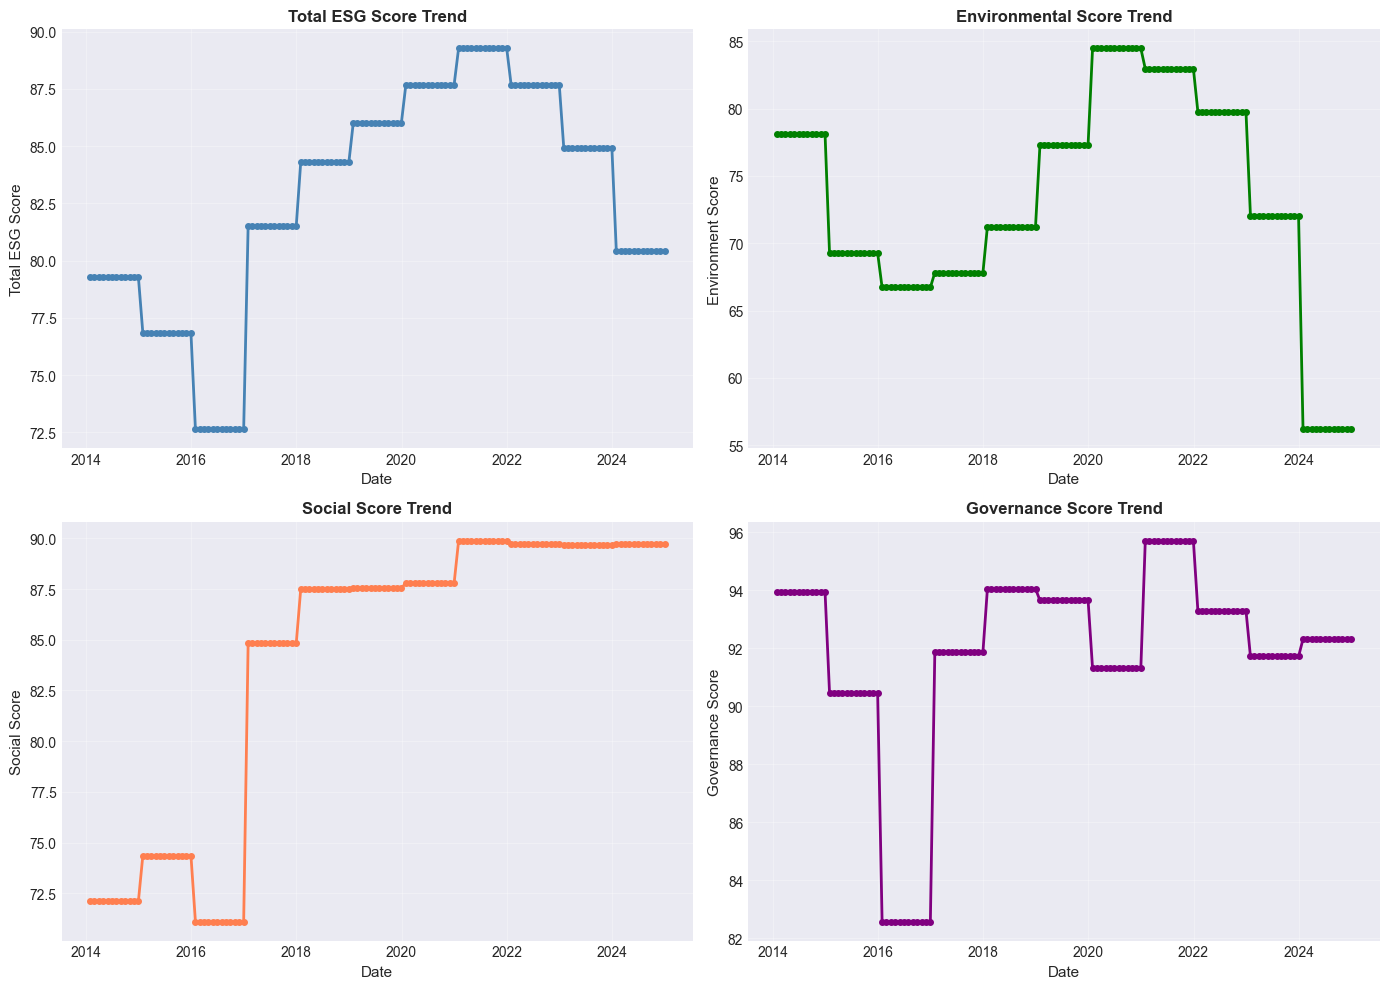


ESG Performance Analysis:
  Current Total ESG: 80.40
  ESG Trend (5Y avg change): -0.12 pts/year
  Latest YoY Change: -5.34%


In [8]:
if not esg_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Total ESG Score
    ax = axes[0, 0]
    ax.plot(esg_df['date'], esg_df['esg_score'], linewidth=2, marker='o', markersize=4, color='steelblue')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Total ESG Score', fontsize=11)
    ax.set_title('Total ESG Score Trend', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Environment Score
    ax = axes[0, 1]
    ax.plot(esg_df['date'], esg_df['environmental_pillar_score'], linewidth=2, marker='o', markersize=4, color='green')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Environment Score', fontsize=11)
    ax.set_title('Environmental Score Trend', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Social Score
    ax = axes[1, 0]
    ax.plot(esg_df['date'], esg_df['social_pillar_score'], linewidth=2, marker='o', markersize=4, color='coral')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Social Score', fontsize=11)
    ax.set_title('Social Score Trend', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Governance Score
    ax = axes[1, 1]
    ax.plot(esg_df['date'], esg_df['governance_pillar_score'], linewidth=2, marker='o', markersize=4, color='purple')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Governance Score', fontsize=11)
    ax.set_title('Governance Score Trend', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ESG momentum analysis
    esg_df['esg_change_yoy'] = esg_df['esg_score'].pct_change(12)
    
    print('\nESG Performance Analysis:')
    print(f'  Current Total ESG: {esg_df["esg_score"].iloc[-1]:.2f}')
    print(f'  ESG Trend (5Y avg change): {esg_df["esg_score"].iloc[-60:].diff().mean():.2f} pts/year')
    print(f'  Latest YoY Change: {esg_df["esg_change_yoy"].iloc[-1]*100:.2f}%')
else:
    print('⚠️ ESG data not available for analysis')

## 6. Expectations Investing Framework

### Step 1: Estimate Current Market Expectations

Using the Extended CAPM expected return as a proxy for market's required return.

In [9]:
if not pep_er.empty:
    # Current market expectations
    required_return = latest_er['ER_annual']
    
    print('='*70)
    print('MARKET EXPECTATIONS EMBEDDED IN CURRENT PRICE')
    print('='*70)
    
    print(f'\nCurrent Price: ${current_price:.2f}')
    print(f'Required Return (Extended CAPM): {required_return*100:.2f}%')
    
    # Compare to historical performance
    historical_return_avg = prices_df['rolling_return_12m'].mean()
    
    print(f'\nHistorical Benchmark:')
    print(f'  Average 12M Return: {historical_return_avg*100:.2f}%')
    
    # Expectation gap
    expectation_gap = required_return - historical_return_avg
    
    print(f'\nExpectation Gap:')
    print(f'  Gap: {expectation_gap*100:.2f}%')
    
    if expectation_gap > 0.02:  # 2% threshold
        print(f'  📈 Market expects ABOVE-AVERAGE performance')
        print(f'     Price may be optimistic - look for catalysts')
    elif expectation_gap < -0.02:
        print(f'  📉 Market expects BELOW-AVERAGE performance')
        print(f'     Price may be pessimistic - potential opportunity')
    else:
        print(f'  ➡️  Market expects IN-LINE performance')
        print(f'     Price fairly reflects historical trends')
else:
    print('⚠️ Expected return data not available. Run extend_capm.py first.')

MARKET EXPECTATIONS EMBEDDED IN CURRENT PRICE

Current Price: $146.33
Required Return (Extended CAPM): 10.00%

Historical Benchmark:
  Average 12M Return: 8.18%

Expectation Gap:
  Gap: 1.82%
  ➡️  Market expects IN-LINE performance
     Price fairly reflects historical trends


### Step 2: Scenario Analysis

Model different scenarios to understand price sensitivity to expectation changes.

In [10]:
# Simple scenario analysis using Gordon Growth Model as proxy
# P = D / (r - g)
# where P = price, D = dividend, r = required return, g = growth rate

# For demonstration, we'll work backwards from current price
# and show what different growth rates imply

if not pep_er.empty:
    r = required_return
    
    # Estimate implied growth rates for different scenarios
    scenarios = {
        'Bear Case': r - 0.08,  # 8% implied growth
        'Base Case': r - 0.06,  # 6% implied growth  
        'Bull Case': r - 0.04,  # 4% implied growth
    }
    
    print('='*70)
    print('SCENARIO ANALYSIS: IMPLIED GROWTH EXPECTATIONS')
    print('='*70)
    print(f'\nRequired Return: {r*100:.2f}%')
    print(f'\nWhat growth rates are implied at current price ${current_price:.2f}?\n')
    
    for scenario, implied_growth in scenarios.items():
        print(f'{scenario:12s}: {implied_growth*100:>5.2f}% perpetual growth')
    
    print(f'\n💡 Key Question: Can PepsiCo sustain {scenarios["Base Case"]*100:.1f}% growth?')
    print(f'   - Historical average: {historical_return_avg*100:.2f}%')
    print(f'   - Recent trend: {returns_1y*100:.2f}% (1Y)')
    
    # Price targets under different scenarios
    print(f'\n' + '='*70)
    print('IMPLIED PRICE TARGETS (1-Year Forward)')
    print('='*70 + '\n')
    
    for scenario, implied_growth in scenarios.items():
        # Simple forward projection
        target_price = current_price * (1 + implied_growth)
        upside = (target_price / current_price - 1) * 100
        print(f'{scenario:12s}: ${target_price:>7.2f}  ({upside:>+6.2f}%)')
else:
    print('⚠️ Cannot perform scenario analysis without expected return data')

SCENARIO ANALYSIS: IMPLIED GROWTH EXPECTATIONS

Required Return: 10.00%

What growth rates are implied at current price $146.33?

Bear Case   :  2.00% perpetual growth
Base Case   :  4.00% perpetual growth
Bull Case   :  6.00% perpetual growth

💡 Key Question: Can PepsiCo sustain 4.0% growth?
   - Historical average: 8.18%
   - Recent trend: -7.02% (1Y)

IMPLIED PRICE TARGETS (1-Year Forward)

Bear Case   : $ 149.25  ( +2.00%)
Base Case   : $ 152.18  ( +4.00%)
Bull Case   : $ 155.11  ( +6.00%)


## 7. Expectation Triggers & Catalysts

What events would cause market expectations to change?

In [11]:
print('='*70)
print('EXPECTATION REVISION TRIGGERS')
print('='*70)

print('''
🔺 POSITIVE TRIGGERS (Would increase implied expectations):

1. **Pricing Power Demonstration**
   - Successfully passing through cost inflation
   - Maintaining margins despite input cost pressure
   - Premium product mix shift

2. **Market Share Gains**
   - Outperforming competitors in key categories
   - Successful new product launches
   - International expansion success

3. **Operational Efficiency**
   - Margin expansion through productivity initiatives
   - Supply chain optimization
   - Digital transformation benefits

4. **ESG Leadership**
   - Sustainable packaging innovation
   - Water conservation achievements
   - Health-conscious portfolio shift

🔻 NEGATIVE TRIGGERS (Would decrease implied expectations):

1. **Margin Compression**
   - Unable to offset input cost inflation
   - Promotional spending increase
   - Price competition intensification

2. **Volume Weakness**
   - Market share losses to competitors or private label
   - Consumer trading down
   - Weak international performance

3. **Strategic Missteps**
   - Failed acquisitions or integration
   - Product recalls or safety issues
   - Brand reputation damage

4. **Regulatory/Macro Headwinds**
   - Sugar tax expansion
   - Stricter labeling requirements
   - Currency headwinds
''')

# Show recent volatility around earnings dates (if we had earnings calendar)
print('\n💡 Monitor quarterly earnings for expectation validation/revision')

EXPECTATION REVISION TRIGGERS

🔺 POSITIVE TRIGGERS (Would increase implied expectations):

1. **Pricing Power Demonstration**
   - Successfully passing through cost inflation
   - Maintaining margins despite input cost pressure
   - Premium product mix shift

2. **Market Share Gains**
   - Outperforming competitors in key categories
   - Successful new product launches
   - International expansion success

3. **Operational Efficiency**
   - Margin expansion through productivity initiatives
   - Supply chain optimization
   - Digital transformation benefits

4. **ESG Leadership**
   - Sustainable packaging innovation
   - Water conservation achievements
   - Health-conscious portfolio shift

🔻 NEGATIVE TRIGGERS (Would decrease implied expectations):

1. **Margin Compression**
   - Unable to offset input cost inflation
   - Promotional spending increase
   - Price competition intensification

2. **Volume Weakness**
   - Market share losses to competitors or private label
   - Consumer tr

## 8. Investment Decision Framework

Synthesize analysis into actionable framework.

In [12]:
if not pep_er.empty:
    print('='*70)
    print('EXPECTATIONS INVESTING DECISION FRAMEWORK')
    print('='*70)
    
    print(f'''
**CURRENT SITUATION**
Price: ${current_price:.2f}
Required Return: {required_return*100:.2f}%
Historical Performance: {historical_return_avg*100:.2f}%
Gap: {expectation_gap*100:.2f}%

**INTERPRETATION**
''')
    
    # Decision logic
    if expectation_gap > 0.05:
        recommendation = '🔴 AVOID / UNDERWEIGHT'
        rationale = '''Market expectations appear OPTIMISTIC relative to historical performance.
Price embeds significant growth assumptions that may be difficult to achieve.
Risk/reward unfavorable unless strong catalysts materialize.'''
    
    elif expectation_gap > 0.02:
        recommendation = '🟡 NEUTRAL / HOLD'
        rationale = '''Market expectations moderately above historical trends.
Fair value - monitor for execution on strategic initiatives.
Watch for signs expectations are being met or exceeded.'''
    
    elif expectation_gap > -0.02:
        recommendation = '🟢 NEUTRAL / MARKET PERFORM'
        rationale = '''Market expectations in-line with historical performance.
Price fairly reflects track record.
Suitable for index-weight exposure.'''
    
    else:
        recommendation = '🟢🟢 BUY / OVERWEIGHT'
        rationale = '''Market expectations appear PESSIMISTIC relative to fundamentals.
Price may not fully reflect company's competitive position.
Potential opportunity if company can deliver historical performance levels.'''
    
    print(f'**RECOMMENDATION:** {recommendation}\n')
    print(f'**RATIONALE:**')
    print(rationale)
    
    print(f'''
**KEY MONITORING POINTS**
1. Quarterly earnings vs expectations
2. Margin trends (gross and operating)
3. Volume/mix trends by geography and category
4. ESG score momentum (sustainability positioning)
5. Competitive dynamics and market share

**NEXT STEPS**
1. Review upcoming earnings call for management commentary
2. Compare to peer group (KO, MNST, DPS) expectations
3. Monitor for strategic announcements or guidance changes
4. Reassess if stock moves >5% on new information
''')
else:
    print('⚠️ Cannot generate recommendation without expected return data')

EXPECTATIONS INVESTING DECISION FRAMEWORK

**CURRENT SITUATION**
Price: $146.33
Required Return: 10.00%
Historical Performance: 8.18%
Gap: 1.82%

**INTERPRETATION**

**RECOMMENDATION:** 🟢 NEUTRAL / MARKET PERFORM

**RATIONALE:**
Market expectations in-line with historical performance.
Price fairly reflects track record.
Suitable for index-weight exposure.

**KEY MONITORING POINTS**
1. Quarterly earnings vs expectations
2. Margin trends (gross and operating)
3. Volume/mix trends by geography and category
4. ESG score momentum (sustainability positioning)
5. Competitive dynamics and market share

**NEXT STEPS**
1. Review upcoming earnings call for management commentary
2. Compare to peer group (KO, MNST, DPS) expectations
3. Monitor for strategic announcements or guidance changes
4. Reassess if stock moves >5% on new information



## 9. Summary Dashboard

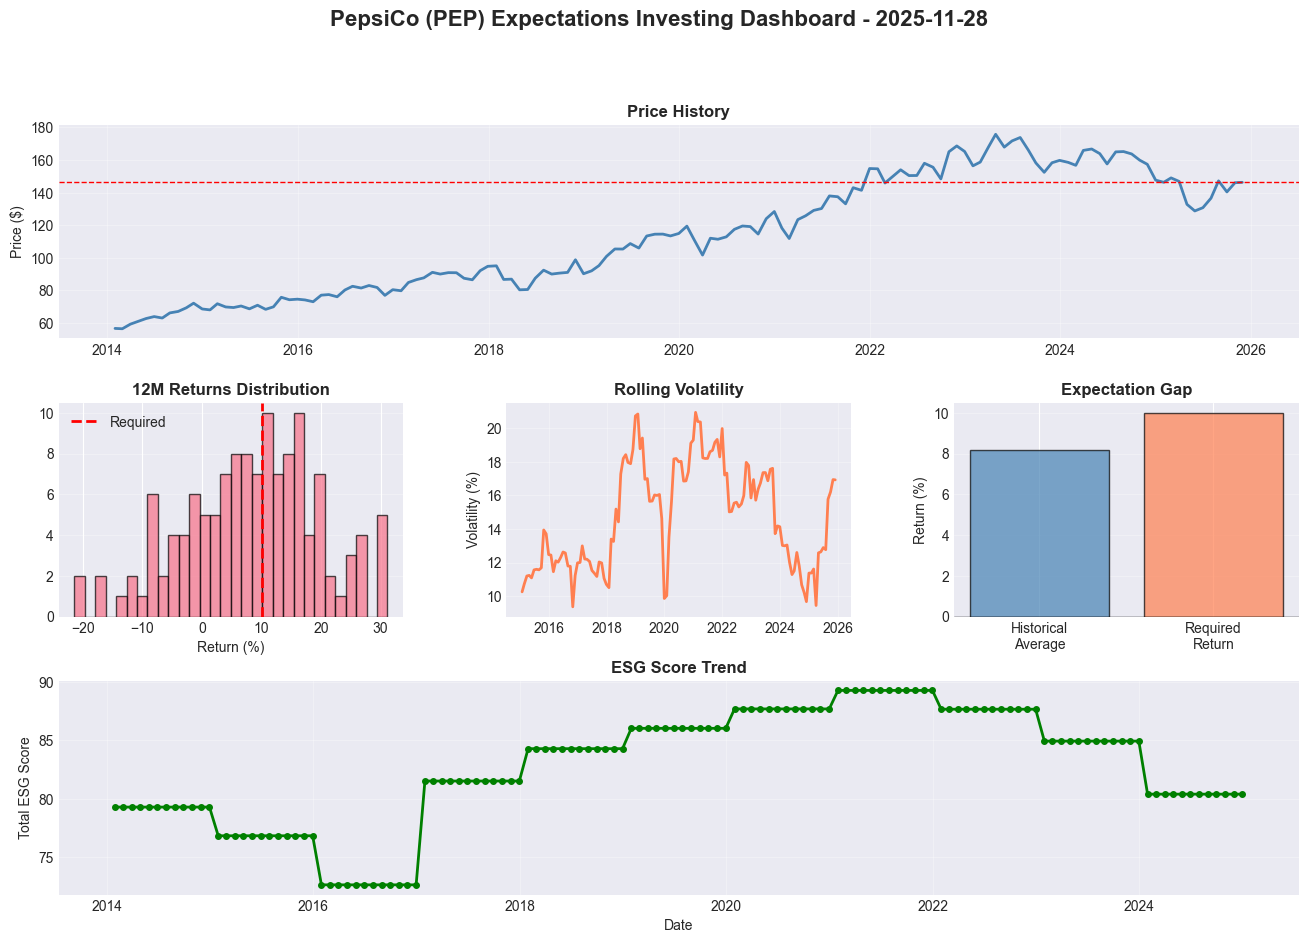

✅ Dashboard complete


In [13]:
# Create summary dashboard
if not pep_er.empty:
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Price chart
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(prices_df['date'], prices_df['adj_close'], linewidth=2, color='steelblue')
    ax1.axhline(current_price, color='red', linestyle='--', linewidth=1)
    ax1.set_title('Price History', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.grid(alpha=0.3)
    
    # Returns distribution
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(prices_df['rolling_return_12m'].dropna()*100, bins=30, edgecolor='black', alpha=0.7)
    ax2.axvline(required_return*100, color='red', linestyle='--', linewidth=2, label='Required')
    ax2.set_title('12M Returns Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Return (%)')
    ax2.legend()
    ax2.grid(alpha=0.3, axis='y')
    
    # Volatility
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(prices_df['date'], prices_df['rolling_vol_12m']*100, linewidth=2, color='coral')
    ax3.set_title('Rolling Volatility', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Volatility (%)')
    ax3.grid(alpha=0.3)
    
    # Expectation gap
    ax4 = fig.add_subplot(gs[1, 2])
    gap_data = [historical_return_avg*100, required_return*100]
    gap_labels = ['Historical\nAverage', 'Required\nReturn']
    colors_gap = ['steelblue', 'coral']
    ax4.bar(gap_labels, gap_data, color=colors_gap, edgecolor='black', alpha=0.7)
    ax4.set_title('Expectation Gap', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Return (%)')
    ax4.axhline(0, color='black', linewidth=1)
    ax4.grid(alpha=0.3, axis='y')
    
    # ESG trend (if available)
    if not esg_df.empty:
        ax5 = fig.add_subplot(gs[2, :])
        ax5.plot(esg_df['date'], esg_df['esg_score'], linewidth=2, marker='o', markersize=4, color='green')
        ax5.set_title('ESG Score Trend', fontsize=12, fontweight='bold')
        ax5.set_ylabel('Total ESG Score')
        ax5.set_xlabel('Date')
        ax5.grid(alpha=0.3)
    
    fig.suptitle(f'PepsiCo (PEP) Expectations Investing Dashboard - {current_date.date()}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    
    print('✅ Dashboard complete')
else:
    print('⚠️ Cannot generate dashboard without expected return data')

## 10. References & Further Reading

### Core Expectations Investing Framework
- **Mauboussin & Rappaport (2001)**: *Expectations Investing: Reading Stock Prices for Better Returns*
- **Mauboussin (2020)**: "Expectations Investing Update" - Research paper
- **Rappaport (1986)**: *Creating Shareholder Value*

### Valuation & Expected Returns
- **Sharpe (1964)**: Capital Asset Pricing Model
- **Pastor & Stambaugh (2021)**: Sustainable Investing in Equilibrium

### Company-Specific Research
- PepsiCo Investor Relations: https://www.pepsico.com/investors
- Latest 10-K and 10-Q filings
- Earnings call transcripts

---

**Notebook Complete!** ✅

*Remember: Expectations Investing is about probabilistic thinking and identifying where market expectations deviate from fundamental reality.*